# A/B Testing from Scratch: Bayesian Approach

We reuse the simple problem of comparing two online ads campaigns (or teatments, user interfaces or slot machines). We details how Bayesian A/B test is conducted and highlights the differences between it and the frequentist approaches. Readers are encouraged to tinker with the widgets provided in order to explore the impacts of each parameter.

In [1]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *
from mizani import *

#stats
import scipy as sp
import statsmodels as sm

import warnings
warnings.filterwarnings('ignore')
import collections

## Start with A Problem

A typical situation marketers (research physicians, UX researchers, or gamblers) find themselves in is that they have two variations of ads (treatments, user interfaces, or slot machines) and want to find out which one has the better performance in the long run.

Practitioners know this as A/B testing and statisticians as **hypothesis testing**. Consider the following problem. We are running an online ads campaign `A` for a period of time, but now we think a new ads variation might work better so we run an experiemnt by dividing our audience in half: one sees the existing campaign `A` whereas the other sees a new campaign `B`. Our performance metric is conversion (sales) per click (ignore [ads attribution problem](https://support.google.com/analytics/answer/1662518) for now). After the experiment ran for two months, we obtain daily clicks and conversions of each campaign and determine which campaign has the better performance.

We simulate the aforementioned problem with both campaigns getting randomly about a thousand clicks per day. The secrete we will pretend to not know is that hypothetical campaign `B` has slightly better conversion rate than `A` in the long run (10.5% vs 10%). With this synthetic data, we will explore some useful statistical concepts and exploit them for our frequentist A/B testing.

In [2]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(50,100,150,size=nb_days*2).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    return conv_days

conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.105,
                          nb_days = 24,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
0,0,125,87,12,9,125,87,12,9,0.096000,0.103448
1,1,114,86,11,9,239,173,23,18,0.096234,0.104046
2,2,67,91,6,9,306,264,29,27,0.094771,0.102273
3,3,96,103,9,10,402,367,38,37,0.094527,0.100817
4,4,89,125,9,13,491,492,47,50,0.095723,0.101626


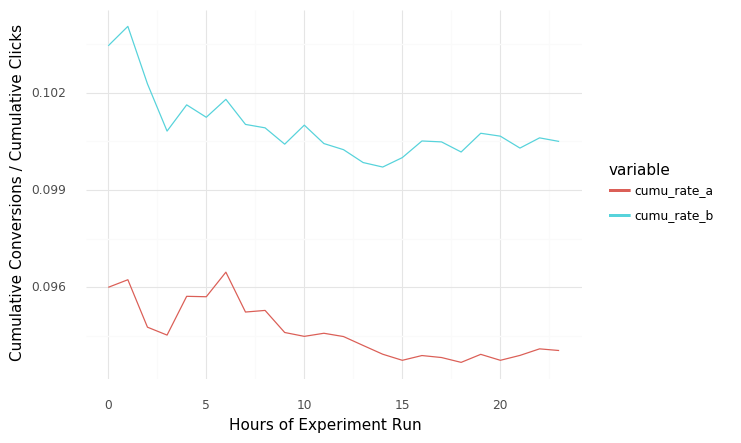

<ggplot: (-9223372036578797508)>

In [3]:
rates_df = conv_days[['click_day','cumu_rate_a','cumu_rate_b']].melt(id_vars='click_day')
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Hours of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

In [4]:
#sum after 2 months
conv_df = pd.DataFrame({'campaign_id':['A','B'], 'clicks':[conv_days.click_a.sum(),conv_days.click_b.sum()],
                        'conv_cnt':[conv_days.conv_a.sum(),conv_days.conv_b.sum()]})
conv_df['conv_per'] =  conv_df['conv_cnt'] / conv_df['clicks']
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,2488,234,0.094051
1,B,2209,222,0.100498


## Think Like A Bayesian

The core idea of Bayesian A/B testing is to formulate a posterior distribution for each variation. Recall that frequentist approach does not do this; it instead first assume a null hypothesis that there is no difference between the variations and see the data to determine the false positive rate. The advantage is that we can have hypotheses directly about the true values we are interested in such as the conversion rate for each variation. The cost is that now we cannot leverate central limit theorem to assume normal distribution for our hypotheses; instead we need to construct our own distributions, called **posterior distriubtion**, using Bayes' Rule:

\begin{align}
P(H|D) &= \frac{P(H \cap D)}{P(D)} \\
&= \frac{P(D|H)P(H)}{P(D)} \text{; chain rule of probability}\\ 
& = \frac{P(D|H)P(H)}{\sum_{j=1}^k P(D|H_j)P(H_j)} \text{; summing over all possible hypotheses}
\end{align}
where $H$ is the hypothesis or model and $D$ is the data or evidence

* $P(H|D)$ is the probability of the hypothesis being true given the observed data, called the **posterior**. This is the distribution we use to estimate the true values such as true conversion rates in the Bayesian approach.
* $P(D|H)$ is the probability of seeing the data given that the hypothesis is true, called the **likelihood**, this is similar to p-value of rejection of the null hypothesis under frequentist approach.
* $P(H)$ is the probability of the hypothesis being true aka our belief in the hypothesis, called the **prior**. Refer to a table of [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) to choose the suitable prior for your posterior and likelihood.
* $P(D)$ is the probability of the data being present, called the **evidence**. 

## Derive The Posterior Distribution

In our case, the likelihood that we would see this set of clicks and conversions data given that the true conversion rate is `p` can be described as the probability mass function of a Bernouilli distribution:

\begin{align}
P(D|H) &= \prod_{i=1}^{n} p^{x_i} (1-p)^{1-x_i} \\
&= p^{\sum_{i=1}^{n} x_i} (1-p)^{\sum_{i=1}^{n} (1-x_i)}
\end{align}

where $x_i$ is the binary flag for conversion and `p` is the true conversion rate by the hypothesis $H$.

The prior is a beta distribution with the following probability density function:

\begin{align}
P(H) &= \frac{p^{\alpha-1} (1-p)^{\beta-1}}{B(\alpha,\beta)} 
\end{align}

where $\alpha$ and $\beta$ are hyperparameters correlated with number of successes and failures respectively, and $B(\alpha, \beta)$ is the beta function to normalize the distribution to be between 0 and 1. Intuitively, the beta distribution is shaped by the number of successes and failures initialized by $\alpha$ and $\beta$; moreover, higher number means we are more certain about our distribution thus resulting in less variance:

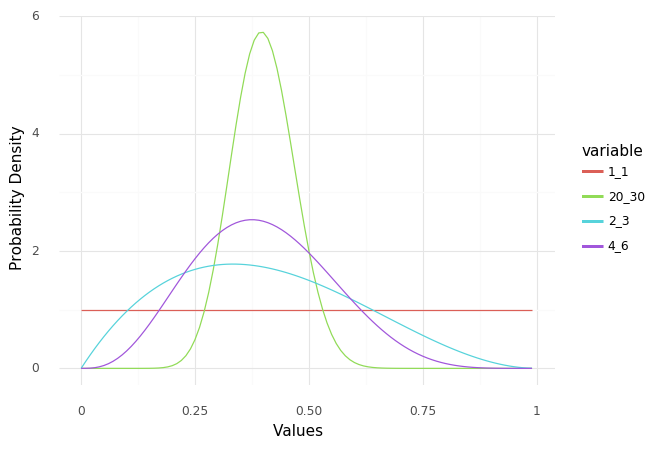

<ggplot: (305079188)>

In [5]:
beta_df = pd.DataFrame({'x': [i/100 for i in range(100)],
                        '1_1': [sp.stats.beta.pdf(i/100, a=1,b=1) for i in range(100)],
                        '2_3': [sp.stats.beta.pdf(i/100, a=2,b=3) for i in range(100)],
                        '4_6': [sp.stats.beta.pdf(i/100, a=4,b=6) for i in range(100)],
                        '20_30': [sp.stats.beta.pdf(i/100, a=20,b=30) for i in range(100)],
                       }).melt(id_vars='x')
g = (ggplot(beta_df,aes(x='x',y='value',color='variable')) +
     geom_line() + theme_minimal() +
     xlab('Values') + ylab('Probability Density')
    )
g

Here we notice that the evidence $P(D)$ and the normalizing factor $B(\alpha, \beta)$ are constants in regards to our hypothesis so we can bypass them and consider that our posterior distribution is proportional to:

\begin{align}
P(H|D) &\propto \left( p^{\sum_{i=1}^{n} x_i} (1-p)^{\sum_{i=1}^{n} (1-x_i)} \right) \left(p^{\alpha-1} (1-p)^{\beta-1} \right) \\
&\propto p^{\alpha + \sum_{i=1}^{n} x_i - 1} (1-p)^{\beta + \sum_{i=1}^{n} (1-x_i) -1}
\end{align}

We can see that our resulting terms are equivalent to an unnormalized beta distribution. Thus, by normalizing it, we can get a beta distribution as our posterior:

\begin{align}
P(H|D) &\propto p^{\alpha + \sum_{i=1}^{n} x_i - 1} (1-p)^{\beta + \sum_{i=1}^{n} (1-x_i) -1} \\
&= \frac{p^{\alpha + \sum_{i=1}^{n} x_i - 1} (1-p)^{\beta + \sum_{i=1}^{n} (1-x_i) -1}}{B(\alpha + \sum_{i=1}^{n} x_i, \beta + \sum_{i=1}^{n} (1-x_i))} \\
&= Beta(\alpha + \text{number of conversions}, \beta + \text{number of non-conversions})
\end{align}

## Choose The Right Prior

We can see that for events that acts like a Bernoulli trial the posterior distribution takes a very convenient form. What we need to do is simply choose a reasonable set of $\alpha$ and $\beta$ for the prior. This is where our assumption factors into a Bayesian A/B test. One way is to set the prior based on past campaign performance; for instance, if we have run this type of campaign and had the average conversion rate of 10%, we can scale the prior according to how certain we are about the conversion rates. Note that different priors can represent 10%, for instance $Beta(1,9)$ and $Beta(10,90)$, but at different level of certainty. See how $Beta(10,90)$ is more pointy around 10% than $Beta(1,9)$.

In [7]:
def plot_beta(a=1,b=9,scaler=1):
    beta_df = pd.DataFrame({'x': [i/100 for i in range(100)],
                           'value': [sp.stats.beta.pdf(i/100, a=a*scaler,b=b*scaler) for i in range(100)]})
    g = (ggplot(beta_df,aes(x='x',y='value')) +
         geom_line() + theme_minimal() +
         xlab('Values') + ylab('Probability Density') +
         ggtitle(f'alpha = {a*scaler}; beta={b*scaler}') 
        )
    return g

widgets.interact(plot_beta, 
                 a=widgets.IntSlider(min=1,max=100,step=1,value=1),
                 b=widgets.IntSlider(min=1,max=100,step=1,value=9),
                 scaler=widgets.FloatSlider(min=0.1,max=100,step=0.5,value=1))

interactive(children=(IntSlider(value=1, description='a', min=1), IntSlider(value=9, description='b', min=1), …

<function __main__.plot_beta(a=1, b=9, scaler=1)>

In [27]:
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,2488,234,0.094051
1,B,2209,222,0.100498


Depending on what we choose as our priors for `A` and `B`, we can derive their posterior distributions as follows. Note that the prior has an impact on the certainty about the values of the posterior (pointiness) and the expected values of the posterior themselves. For instance, even if your observed conversion rate is around 10%, if you gives an absurdly strong prior like $Beta(999,1)$, implying 99.9% conversion rate, your posteriors' expectations can be around 30%.

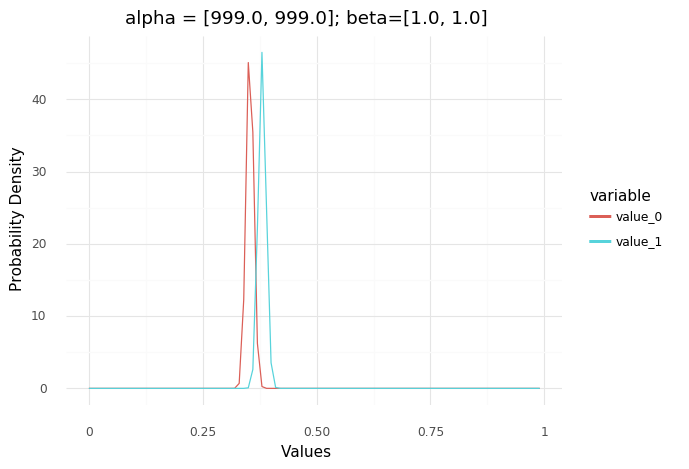

<ggplot: (-9223372036556980792)>

<function __main__.plot_posterior(clicks, conv_cnt, a=1, b=1, scaler=1)>

In [31]:
def plot_posterior(clicks, conv_cnt, a = 1, b = 1, scaler=1):
    beta_df = pd.DataFrame({'x': [i/100 for i in range(100)]})
    if not isinstance(a, collections.MutableSequence):
        a = [a for i in range(len(clicks))]
        b = [b for i in range(len(clicks))]
    for v in range(len(clicks)):
        beta_df[f'value_{v}'] = [sp.stats.beta.pdf(i/100, a=a[v]*scaler + conv_cnt[v], \
                                 b=b[v]*scaler + clicks[v] - conv_cnt[v]) for i in range(100)]
    beta_df = beta_df.melt(id_vars='x')
    g = (ggplot(beta_df,aes(x='x',y='value',color='variable',group='variable')) +
         geom_line() + theme_minimal() +
         xlab('Values') + ylab('Probability Density') +
         ggtitle(f'alpha = {[i*scaler for i in a]}; beta={[i*scaler for i in b]}')
        )
    return g

widgets.interact(plot_posterior, 
                 clicks=fixed(conv_df.clicks),
                 conv_cnt=fixed(conv_df.conv_cnt),
                 a=widgets.IntSlider(min=1,max=1000,step=1,value=999),
                 b=widgets.IntSlider(min=1,max=1000,step=1,value=1),
                 scaler=widgets.FloatSlider(min=1,max=100,step=1,value=1))

## Who Wins by How Much

One way to determine which variation is better is to look at the posterior distributions and their expectations; however, that does not tell us the margin of difference. Since we have a posterior distribution for each variation we can derive what people sometimes confuse with the frequentist p-value: **what is the probability that one variation is better than another?** One way to do this is by using Monte Carlo simulation to draw a large number of samples from each posterior then calculate the percentage of times each sample won.

In [9]:
def sample_proportion(c,n,a=1,b=1,sim_size=100000): return np.random.beta(c+a,n-c+b,sim_size)
def proportion_test_b(c1,c2,n1,n2,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)
    return (p1 > p2).mean()
def proportion_ratio(c1,c2,n1,n2,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)
    return p1/p2
def proportion_ci_b(c1,c2,n1,n2,p_value=0.05,a1=1,a2=1,b1=9,b2=9,sim_size=100000):
    ratios = proportion_ratio(c1,c2,n1,n2,a1,a2,b1,b2,sim_size)
    return np.quantile(ratios,[p_value/2,1-p_value/2])

p_value= proportion_test_b(*conv_df.conv_cnt,*conv_df.clicks)
ratios = proportion_ratio(*conv_df.conv_cnt,*conv_df.clicks)
credible = proportion_ci_b(*conv_df.conv_cnt,*conv_df.clicks,p_value=0.05)
print(f'Probability that A is greater than B: {p_value}')
print(f'Average A/B ratio: {ratios.mean()}')
print(f'Credible interval of A/B ratio: {credible}')

Probability that A is greater than B: 0.22743
Average A/B ratio: 0.9394908467261973
Credible interval of A/B ratio: [0.78622231 1.11331594]


Plotting the ratio of A over B also gives us a look into the magnitude of the difference. For instace, below we can see that for about 80% of the ratio distribution `A` is worse than `B`, and in case that we were wrong `A` is at most about 20% better than `B`. And similar to the frequentist approach, we can calculate the range where most of these ratios (say 95%) falls into, called **credible interval**.

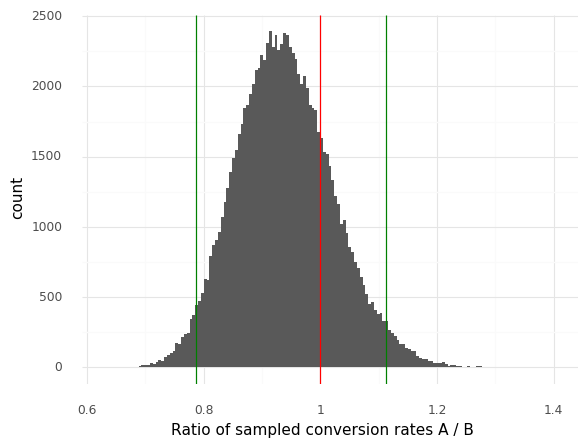

<ggplot: (-9223372036539666709)>

In [10]:
g = (ggplot(pd.DataFrame({'x':ratios}), aes(x='x')) + geom_histogram() +
    theme_minimal() + geom_vline(xintercept=1,color='red') +
    geom_vline(xintercept=credible[0],color='green') + geom_vline(xintercept=credible[1],color='green') + 
    xlab('Ratio of sampled conversion rates A / B')
    ) 
g

## When to Stop: Value Remaining

The freedom from frequentist p-values allows us to not run into the issue that infinite number of samples *always* yield statistical significance even when the true values are exactly the same. As we can see from the plot below, the probility of `A` beating `B` as a result of Monte Carlo sampling from the posteriors stay about 50% when there is no true difference and gradually decreases when there is.

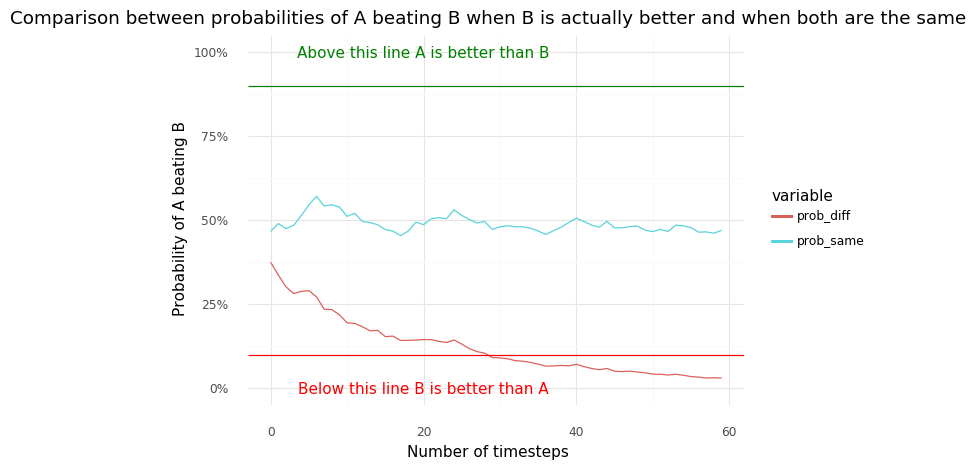

<ggplot: (297784419)>

In [11]:
conv_days2 = gen_campaigns(p1 = 0.10,
                          p2 = 0.10,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days2['prob_same'] = conv_days2.apply(lambda row: proportion_test_b(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
conv_days3 = gen_campaigns(p1 = 0.10,
                          p2 = 0.11,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 

conv_days3['prob_diff'] = conv_days3.apply(lambda row: proportion_test_b(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
prob_df = pd.DataFrame({'click_day':conv_days2.click_day,'prob_same':conv_days2.prob_same,
                        'prob_diff':conv_days3.prob_diff}).melt(id_vars='click_day')
g = (ggplot(prob_df,aes(x='click_day',y='value',color='variable')) +
    geom_line() + theme_minimal() + 
    geom_hline(yintercept=[0.9,0.1],color=['green','red']) +
    xlab('Number of timesteps') + ylab('Probability of A beating B') +
    scale_y_continuous(labels=formatters.percent_format()) +
    annotate("text", label = "Above this line A is better than B", x = 20, y = 1, color = 'green') +
    annotate("text", label = "Below this line B is better than A", x = 20, y = 0, color = 'red') +
    ggtitle('Comparison between probabilities of A beating B when B is actually better and when both are the same')
    )
g

The immediate question then comes up: when should we stop and declare a winner. Technically when there is a true difference, we can stop at any point in time and we will end up choosing the winner at varying degrees of probability (this is a clear improvement from the frequentist approach where we can only say we are not sure most of the time). We can also use a simple rule like if the probability of `A` beating `B` is lower than 10% or greater than 90%, we declare a winner like the plot above.

Stopping criteria for experiments such as ROPE and expected loss as described in [Bayesian A/B Testing: a step-by-step guide](http://www.claudiobellei.com/2017/11/02/bayesian-AB-testing/); here we are using **value remaining** as introduced by [Google](https://support.google.com/analytics/answer/2846882?hl=en). Value remaining per round of experiment is defined as:

$$V_t = \frac{rate_{max}-rate_{opt}}{rate_{opt}}$$

As experiment goes on, we plot the distribution of $V_t$ and stops when the $1-\alpha$ percentile is lower than our threshold. Intuitively, this is to say that we are $1-\alpha$% confident that our "best" arm might be beaten by the margin equals to the threshold. For practical purpose, we try 95th percentile and threshold of 1%.

In [12]:
def value_remaining(c1,c2,n1,n2,q=95,sim_size=100000,a1=1,a2=1,b1=9,b2=9):
    p1 = sample_proportion(c1,n1,a1,b1,sim_size)[:,None]
    p2 = sample_proportion(c2,n2,a2,b2,sim_size)[:,None]
    p = np.concatenate([p1,p2],1)
    p_max = p.max(1)
    best_idx = np.argmax([p1.mean(),p2.mean()])
    p_best = p[:,best_idx]
    vs = (p_max-p_best)/p_best
    return np.percentile(vs,q)

value_remaining(*conv_df.conv_cnt,*conv_df.clicks)

0.0835620586721222

You can see that in the case where the true difference is 1%, value remaining gradually decreases below our 1% threshold. On the other hand, when the true difference is 0%, value remaining always hover around 10%.

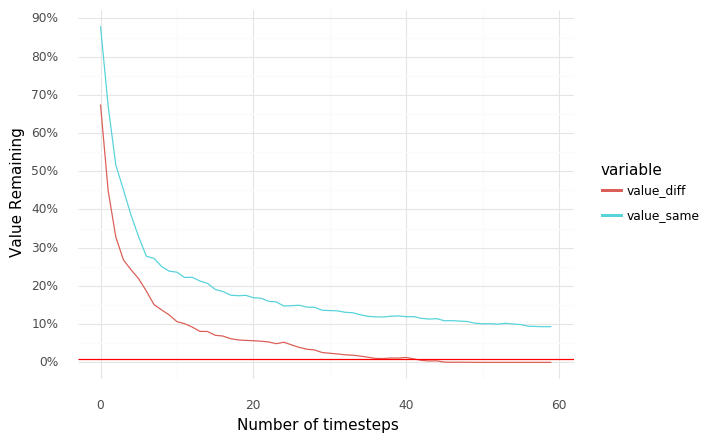

<ggplot: (315113238)>

In [13]:
conv_days2['value_remaining'] = conv_days2.apply(lambda row: value_remaining(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
conv_days3['value_remaining'] = conv_days3.apply(lambda row: value_remaining(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b']),1)
value_df = pd.DataFrame({'click_day':conv_days2.click_day,'value_same':conv_days2.value_remaining,
                        'value_diff':conv_days3.value_remaining}).melt(id_vars='click_day')
g = (ggplot(value_df,aes(x='click_day',y='value',color='variable')) +
    geom_line() + theme_minimal() + 
    geom_hline(yintercept=0.01, color='red') +
    scale_y_continuous(labels=formatters.percent_format(), breaks=[i/100 for i in range(0,101,10)]) +
    xlab('Number of timesteps') + ylab('Value Remaining') 
    )
g

## References

* [An Introduction to Bayesian Thinking: A Companion to the Statistics with R Course](https://statswithr.github.io/book/)
* [Formulas for Bayesian A/B Testing](https://www.evanmiller.org/bayesian-ab-testing.html)
* [20 - Beta conjugate prior to Binomial and Bernoulli likelihoods](https://youtu.be/hKYvZF9wXkk)
* [Bayesian A/B Testing: A Hypothesis Test that Makes Sense](https://www.countbayesie.com/blog/2015/4/25/bayesian-ab-testing)
* [What's the difference between a confidence interval and a credible interval?](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval)
* [Is Bayesian A/B Testing Immune to Peeking? Not Exactly](http://varianceexplained.org/r/bayesian-ab-testing/)